# Player Market Value Prediction - Multi-Model Comparison

**Features:**
- 📊 **Performance stats**: goals, assists, minutes per 90
- 🏆 **Competition embeddings**: league/tournament tier matters
- 🏟️ **Club embeddings**: top clubs vs lower tier
- 👤 **Position embeddings**: GK vs Striker treated differently
- 📈 **NEW: Momentum features**: value trends, velocity
- 👴 **NEW: Age-curve features**: position-specific peak ages
- 📊 **NEW: Percentile rankings**: value vs performance

**Models:** LSTM, GRU, CNN, MLP, Transformer + Ensemble

## 1. Imports

In [25]:
# =============================================================================
# 1. IMPORTS AND ENVIRONMENT SETUP
# =============================================================================
# [Deep Learning & Tensor Processing]
# - torch: The core PyTorch library for tensor computations and dynamic computation graphs.
# - torch.nn: Submodule containing building blocks for neural networks (Layers, Loss functions).
# - torch.nn.functional: Stateless functional interface for operations like activation functions (ReLU).
#
# [Data Handling]
# - pandas: Essential for structured data manipulation (CSVs, Time-series).
# - numpy: Numerical computing library, used here for array operations and math functions (log).
# - sklearn.preprocessing: Used for normalization (StandardScaler) and encoding categorical data (LabelEncoder).
#
# [Hardware Acceleration]
# - The code checks `torch.cuda.is_available()` to determine if an NVIDIA GPU is present.
# - device='cuda' allows we to offload tensor computations to the GPU, providing 10-50x speedup for LSTMs.
# =============================================================================
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Device: cuda
GPU: NVIDIA GeForce RTX 4060 Laptop GPU


## 2. Load Data

In [26]:
# =============================================================================
# 2. LOADING AND TYPE CHECKING CORE DATA
# =============================================================================
# [Data Ingestion]
# We load the relational database tables from CSV files into Pandas DataFrames.
# - players.csv: 32k+ rows of static player attributes.
# - player_valuations.csv: The temporal target variable. Each row is a valuation update.
#
# [Type Casting - Optimization]
# - Dates in CSVs are read as strings (object type) by default.
# - We explicitly convert them to `datetime64[ns]` using `pd.to_datetime`.
# - Why? String comparisons are slow (O(N*L)). Datetime operations are numerical (O(1) relative comparisons).
# - errors='coerce': Handles malformed dates by turning them into NaT (Not a Time) instead of crashing.
# =============================================================================
players_df = pd.read_csv('players.csv')
valuations_df = pd.read_csv('player_valuations.csv')
appearances_df = pd.read_csv('appearances.csv')
competitions_df = pd.read_csv('competitions.csv')
clubs_df = pd.read_csv('clubs.csv')

players_df['date_of_birth'] = pd.to_datetime(players_df['date_of_birth'], errors='coerce')
valuations_df['date'] = pd.to_datetime(valuations_df['date'])
appearances_df['date'] = pd.to_datetime(appearances_df['date'])

print(f"Players: {len(players_df):,} | Valuations: {len(valuations_df):,} | Appearances: {len(appearances_df):,}")
print(f"Competitions: {len(competitions_df)} | Clubs: {len(clubs_df)}")

Players: 32,601 | Valuations: 496,606 | Appearances: 1,706,806
Competitions: 44 | Clubs: 439


In [27]:
# =============================================================================
# 3. LOADING HIGH-FREQUENCY DATA
# =============================================================================
# [Granularity Management]
# - game_events.csv contains millions of rows (every card, sub, goal per match).
# - transfers.csv tracks player movement between clubs (adjacency changes).
# - parse_dates=['date']: We use the read_csv parameter directly for efficiency here.
#   This avoids creating an intermediate string array in memory before conversion.
# =============================================================================
game_events = pd.read_csv('game_events.csv', parse_dates=['date'])
transfers = pd.read_csv('transfers.csv', parse_dates=['transfer_date'])
games = pd.read_csv('games.csv', parse_dates=['date'])

print(f"Game Events: {len(game_events):,} | Transfers: {len(transfers):,} | Games: {len(games):,}")

Game Events: 1,035,043 | Transfers: 79,646 | Games: 74,026


In [28]:
# =============================================================================
# 4. FEATURE ENGINEERING: AGGREGATION PIPELINE
# =============================================================================
# [Dimensionality Reduction]
# Motivation: Our target (market value) changes roughly monthly/quarterly.
# Our input (game events) happens daily. We must alignment them temporally.
#
# [Algorithm]
# 1. Discretization: `dt.to_period('M')` buckets exact timestamps into Monthly intervals.
#    2020-01-15 -> 2020-01.
# 2. Grouping: We gather all events for a specific (player, month) tuple.
# 3. Pivot (Unstack): We transform the categorical value 'type' column into multiple feature columns.
#    - Before: [Player A, Jan, 'Goal'], [Player A, Jan, 'Card']
#    - After:  player_id | month | Goals | Cards
#    This is crucial for creating a fixed-size feature vector for the Neural Network.
# =============================================================================
game_events['year_month'] = game_events['date'].dt.to_period('M')

# Pivot event types to columns
events_agg = game_events.groupby(['player_id', 'year_month', 'type']).size().unstack(fill_value=0).reset_index()

# Rename columns to match expected feature names
event_cols_map = {
    'Goals': 'ge_goals_month',
    'Assists': 'ge_assists_month',
    'Yellow card': 'ge_yellow_cards_month',
    'Red card': 'ge_red_cards_month'
}

for old_col, new_col in event_cols_map.items():
    if old_col in events_agg.columns:
        events_agg[new_col] = events_agg[old_col]
    else:
        events_agg[new_col] = 0

# Keep only relevant columns
events_features = events_agg[['player_id', 'year_month', 'ge_goals_month', 'ge_assists_month', 
                               'ge_yellow_cards_month', 'ge_red_cards_month']].copy()

print(f"Game Events Features: {len(events_features):,} rows")

Game Events Features: 514,810 rows


In [29]:
# =============================================================================
# 5. FEATURE ENGINEERING: TEMPORAL LOOKBACK (TRANSFERS)
# =============================================================================
# [Algorithm: Time-Travel Safe Logic]
# Goal: For any given valuation date, what was the LAST transfer fee paid?
# Challenge: We must avoid 'Look-ahead Bias' (using future transfer info to predict past value).
#
# [Implementation Details]
# 1. Iterate through every unique (player, valuation_month) tuple.
# 2. Filter `transfers_df` for rows where `transfer_date` < `valuation_month`.
#    - This strict inequality enforces causality.
# 3. State Retrieval:
#    - `latest.iloc[-1]`: Gets the most recent transfer chronologically.
#    - `time_since`: Calculates decay. (Current Time - Transfer Time).
#      This serves as a 'recency' feature for the model.
#
# Complexity: This is roughly O(N_valuations * log(N_transfers)) due to filtering.
# =============================================================================
if 'year_month' not in valuations_df.columns:
    valuations_df['year_month'] = valuations_df['date'].dt.to_period('M')

# Get transfer features for each player
def compute_transfer_features(transfers_df, valuations_df):
    """Compute transfer-based features for each player-month"""
    
    # Prepare transfers data
    transfers_df = transfers_df.copy()
    transfers_df['year_month'] = transfers_df['transfer_date'].dt.to_period('M')
    
    # Get unique player-months from valuations
    player_months = valuations_df[['player_id', 'year_month']].drop_duplicates()
    
    results = []
    for _, row in player_months.iterrows():
        pid = row['player_id']
        ym = row['year_month']
        
        # Get transfers before this month
        prior_transfers = transfers_df[(transfers_df['player_id'] == pid) & 
                                        (transfers_df['year_month'] < ym)]
        
        if len(prior_transfers) == 0:
            results.append({
                'player_id': pid,
                'year_month': ym,
                'prev_transfer_fee': 0,
                'transfer_count': 0,
                'avg_transfer_fee': 0,
                'time_since_transfer_months': 120  # Default large value
            })
        else:
            # Get numeric transfer fees only
            fees = pd.to_numeric(prior_transfers['transfer_fee'], errors='coerce').fillna(0)
            latest = prior_transfers.sort_values('transfer_date').iloc[-1]
            latest_fee = pd.to_numeric(latest['transfer_fee'], errors='coerce')
            if pd.isna(latest_fee):
                latest_fee = 0
            
            # Months since last transfer
            latest_month = latest['year_month']
            months_diff = (ym.to_timestamp() - latest_month.to_timestamp()).days / 30
            
            results.append({
                'player_id': pid,
                'year_month': ym,
                'prev_transfer_fee': latest_fee,
                'transfer_count': len(prior_transfers),
                'avg_transfer_fee': fees.mean() if len(fees) > 0 else 0,
                'time_since_transfer_months': months_diff
            })
    
    return pd.DataFrame(results)

# Compute transfer features (this may take a few minutes)
print("Computing transfer features...")
transfer_features = compute_transfer_features(transfers, valuations_df)
print(f"Transfer Features: {len(transfer_features):,} rows")

Computing transfer features...
Transfer Features: 494,192 rows


## 3. Feature Engineering with Competition & Club

In [30]:
# =============================================================================
# 6. FEATURE ENGINEERING: MAIN STATS AGGREGATION
# =============================================================================
# [Aggregation Logic]
# We condense the `appearances` table to get one row per player-year-month.
# - Sum: goals, assists, minutes, yellow_cards (Accumulating stats).
# - First: competition_id, club_id (Contextual state).
#
# [Normalization - Per 90]
# We create rate statistics (`_p90`) to normalize for playing time.
# Formula: (Stat / Minutes Played) * 90
# - Edge Case Handling: We use np.where(minutes>0, ...) to avoid DivisionByZero errors.
#   Simply adding small epsilon can introduce noise; explicit masking is cleaner.
# =============================================================================
appearances_df['year_month'] = appearances_df['date'].dt.to_period('M')

# Aggregate by player-month (OPTIMIZED: using 'first' instead of slow mode())
app_agg = appearances_df.groupby(['player_id', 'year_month']).agg({
    'game_id': 'count',
    'minutes_played': ['sum', 'mean'],
    'goals': 'sum',
    'assists': 'sum',
    'yellow_cards': 'sum',
    'red_cards': 'sum',
    'competition_id': 'first',
    'player_club_id': 'first'
}).reset_index()

app_agg.columns = ['player_id', 'year_month', 'games', 'minutes', 'avg_min', 
                   'goals', 'assists', 'yellows', 'reds', 'competition_id', 'club_id']

# Per-90 stats
app_agg['goals_p90'] = np.where(app_agg['minutes'] > 0, app_agg['goals'] / app_agg['minutes'] * 90, 0)
app_agg['assists_p90'] = np.where(app_agg['minutes'] > 0, app_agg['assists'] / app_agg['minutes'] * 90, 0)
app_agg['ga_p90'] = app_agg['goals_p90'] + app_agg['assists_p90']

print(f"Player-month records: {len(app_agg):,}")
print(f"Unique competitions: {app_agg['competition_id'].nunique()}")
print(f"Unique clubs: {app_agg['club_id'].nunique()}")

Player-month records: 573,466
Unique competitions: 43
Unique clubs: 1062


In [31]:
# =============================================================================
# 7. FEATURE ENGINEERING: ROLLING WINDOWS (TREND ANALYSIS)
# =============================================================================
# [Signal Processing]
# Raw monthly stats are noisy (high variance). A player might score 3 goals one month and 0 the next.
# We smooth this signal using Moving Averages (Rolling Windows).
#
# [Implementation]
# 1. Sort by Player and Date (Crucial for correct windowing).
# 2. `groupby('player_id')`: Ensures the window does not cross over from Player A to Player B.
# 3. `rolling(window=3, min_periods=1)`:
#    - Looks at [t-2, t-1, t].
#    - min_periods=1: Computes value even if only 1 month of history exists (start of career).
#Result: 'goals_3m' captures 'Recent Form', 'goals_6m' captures 'Season Form'.
# =============================================================================
app_agg = app_agg.sort_values(['player_id', 'year_month'])
for col in ['goals', 'assists', 'minutes', 'games', 'ga_p90']:
    app_agg[f'{col}_3m'] = app_agg.groupby('player_id')[col].transform(lambda x: x.rolling(3, 1).mean())
    app_agg[f'{col}_6m'] = app_agg.groupby('player_id')[col].transform(lambda x: x.rolling(6, 1).mean())

# Add player info
player_info = players_df[['player_id', 'name', 'position', 'date_of_birth', 'height_in_cm', 'current_club_id']].copy()
df = app_agg.merge(player_info, on='player_id', how='left')

# Use current_club_id if club_id is missing
df['club_id'] = df['club_id'].fillna(df['current_club_id']).fillna(0).astype(int)

df['month_date'] = df['year_month'].dt.to_timestamp()
df['age'] = ((df['month_date'] - df['date_of_birth']).dt.days / 365.25).fillna(25)
df['height_in_cm'] = df['height_in_cm'].fillna(180)

print(f"Features added with club and competition info")

Features added with club and competition info


In [32]:
# =============================================================================
# 8. TARGET DEFINITION AND DISTRIBUTION SHAPING
# =============================================================================
# [Merging Strategy]
# We merge the calculated features onto the `valuations_df` backbone.
# This creates our Master Analytical Table (MAT).
#
# [Target Engineering]
# 1. Horizon: We want to predict value `N` months ahead.
#    `df.groupby('player_id')['market_value'].shift(-3)`
#    - Negative shift moves future values 'up' to the current row.
#
# 2. Log Transformation (Distribution Stabilization):
#    Market values follow a Power Law (Zipfian distribution) - few players are worth 100M+,
#    most are <1M. This skew makes MSE gradients unstable.
#    - Solution: Apply `np.log1p(x)` (Natural Log(1+x)).
#    - This compresses the range and makes the distribution more Gaussian-like.
# =============================================================================
valuations_df['year_month'] = valuations_df['date'].dt.to_period('M')
vals = valuations_df.sort_values('date').groupby(['player_id', 'year_month']).last().reset_index()
vals = vals[['player_id', 'year_month', 'market_value_in_eur']]
vals.columns = ['player_id', 'year_month', 'value']

df = df.merge(vals, on=['player_id', 'year_month'], how='left')
df = df.sort_values(['player_id', 'year_month'])
df['value'] = df.groupby('player_id')['value'].ffill()
df['target'] = df.groupby('player_id')['value'].shift(-3)

# Log transform
df['log_value'] = np.log1p(df['value'].fillna(0))
df['log_target'] = np.log1p(df['target'].fillna(0))

# Filter valid (cap at €200M to remove outliers)
df = df[df['target'].notna() & (df['target'] > 0) & (df['target'] < 2e8)].copy()
print(f"Valid records: {len(df):,}")
print(f"Value range: €{df['target'].min():,.0f} to €{df['target'].max():,.0f}")

Valid records: 468,238
Value range: €10,000 to €180,000,000


## 3.5 NEW: Momentum Features

In [33]:
# =============================================================================
# 9. MOMENTUM FEATURES (CALCULUS OF VALUE)
# =============================================================================
# [Concept]
# We define Market Value as a dynamic system. We want to capture its derivatives.
# - Velocity: How fast is value changing? (current - prev).
# - Acceleration: Is the growth slowing down?
#
# [Mathematical Derivation]
# 1. Lag Features: shift(1) gets t-1 value.
# 2. Percentage Change: (Value_t - Value_t-1) / Value_t-1
# 3. Clipping: We clamp extreme jumps (e.g., +1000% for a rookie getting first value)
#    to [-1, 5] range to prevent exploding gradients in the Neural Network.
# =============================================================================
df['value_1m_ago'] = df.groupby('player_id')['value'].shift(1)
df['value_3m_ago'] = df.groupby('player_id')['value'].shift(3)
df['value_6m_ago'] = df.groupby('player_id')['value'].shift(6)

# Value change percentages (momentum)
df['value_change_1m'] = (df['value'] - df['value_1m_ago']) / df['value_1m_ago'].clip(lower=10000)
df['value_change_3m'] = (df['value'] - df['value_3m_ago']) / df['value_3m_ago'].clip(lower=10000)
df['value_change_6m'] = (df['value'] - df['value_6m_ago']) / df['value_6m_ago'].clip(lower=10000)

# Clip extreme changes
for col in ['value_change_1m', 'value_change_3m', 'value_change_6m']:
    df[col] = df[col].clip(-0.8, 3.0).fillna(0)

# Value velocity (acceleration of change)
df['value_velocity'] = df['value_change_1m'] - df.groupby('player_id')['value_change_1m'].shift(1)
df['value_velocity'] = df['value_velocity'].clip(-0.5, 0.5).fillna(0)

print("✓ Added momentum features: value_change_1m, value_change_3m, value_change_6m, value_velocity")

✓ Added momentum features: value_change_1m, value_change_3m, value_change_6m, value_velocity


In [34]:
# =============================================================================
# 10. FEATURE INTEGRATION
# =============================================================================
# [Join Logic]
# - Type: LEFT JOIN. We keep all valuation rows.
# - Keys: `player_id`, `year_month`.
# - Imputation: Events/Transfers might be missing for some months.
#   We fill specific columns with 0 (assuming no event occurred if record missing).
#
# [Ratio Engineered Features]
# - `goal_involvement_rate`: Combined G+A per match.
# - `rolling_events`: Apply the same smoothing (rolling mean) to event counts
#   to match the statistical properties of the performance features.
# =============================================================================
df = df.merge(events_features, on=['player_id', 'year_month'], how='left')

# Merge transfer features  
df = df.merge(transfer_features, on=['player_id', 'year_month'], how='left')

# Fill missing values with 0
new_feature_cols = ['ge_goals_month', 'ge_assists_month', 'ge_yellow_cards_month', 'ge_red_cards_month',
                    'prev_transfer_fee', 'transfer_count', 'avg_transfer_fee', 'time_since_transfer_months']
for col in new_feature_cols:
    if col in df.columns:
        df[col] = df[col].fillna(0)

# Create rolling features from game events
df = df.sort_values(['player_id', 'year_month'])
df['ge_goals_rolling_6m'] = df.groupby('player_id')['ge_goals_month'].transform(lambda x: x.rolling(6, 1).mean())
df['ge_assists_rolling_6m'] = df.groupby('player_id')['ge_assists_month'].transform(lambda x: x.rolling(6, 1).mean())

# Goal involvement rate (goals + assists) / games - use existing games column
df['goal_involvement_rate'] = np.where(df['games'] > 0, 
                                        (df['ge_goals_month'] + df['ge_assists_month']) / df['games'], 0)
df['goal_involvement_rate'] = df['goal_involvement_rate'].clip(0, 3).fillna(0)

# Log transform transfer fees
df['log_prev_transfer_fee'] = np.log1p(df['prev_transfer_fee'])
df['log_avg_transfer_fee'] = np.log1p(df['avg_transfer_fee'])

print(f"✓ Added game events and transfer features")
print(f"  New columns: {new_feature_cols}")

✓ Added game events and transfer features
  New columns: ['ge_goals_month', 'ge_assists_month', 'ge_yellow_cards_month', 'ge_red_cards_month', 'prev_transfer_fee', 'transfer_count', 'avg_transfer_fee', 'time_since_transfer_months']


## 3.6 NEW: Age-Value Curve Features

In [35]:
# =============================================================================
# 11. DOMAIN KNOWLEDGE INJECTION (AGE CURVE)
# =============================================================================
# [Hueristic Encoding]
# Football domain knowledge suggests predictable career arcs based on position.
# - Goalkeepers peak later (~29).
# - Attackers peak earlier (~26).
#
# [Feature Construction]
# - `years_from_peak`: Signed distance. Negative = Developing, Positive = Declining.
# - `age_trajectory`: A custom non-linear function simulating biological peak.
#   value = 1 / (1 + abs(age - peak))
#   This gives the model a strong hint about expected value based on lifecycle stage.
# =============================================================================
PEAK_AGES = {
    'Goalkeeper': 30,
    'Defender': 28,
    'Midfield': 27,
    'Attack': 26,
    'Unknown': 27
}

# Simplify position to main categories
def simplify_position(pos):
    if pd.isna(pos): return 'Unknown'
    pos = str(pos).lower()
    if 'goal' in pos or 'keeper' in pos: return 'Goalkeeper'
    if 'back' in pos or 'defender' in pos: return 'Defender'
    if 'mid' in pos: return 'Midfield'
    if 'forward' in pos or 'wing' in pos or 'striker' in pos or 'attack' in pos: return 'Attack'
    return 'Unknown'

df['position_group'] = df['position'].apply(simplify_position)
df['peak_age'] = df['position_group'].map(PEAK_AGES)

# Years from peak (negative = before peak, positive = after peak)
df['years_from_peak'] = df['age'] - df['peak_age']

# Expected value trajectory based on age
df['age_trajectory'] = np.where(
    df['years_from_peak'] < 0,
    0.02 * np.abs(df['years_from_peak']),  # Growth phase
    -0.05 * df['years_from_peak']  # Decline phase
)

# Age squared for non-linear effects
df['age_squared'] = (df['age'] - 27) ** 2 / 100

print("✓ Added age-curve features: years_from_peak, age_trajectory, age_squared")
print(f"Position groups: {df['position_group'].value_counts().to_dict()}")

✓ Added age-curve features: years_from_peak, age_trajectory, age_squared
Position groups: {'Defender': 162196, 'Midfield': 144395, 'Attack': 129752, 'Goalkeeper': 31555, 'Unknown': 340}


## 3.7 NEW: Percentile Rankings

In [36]:
# =============================================================================
# 12. RELATIVE RANKING (CONTEXTUALIZATION)
# =============================================================================
# [Statistical Binning]
# A raw '5 goals' means nothing without context. Is it a Defender? Is it the Premier League?
#
# [Algorithm]
# 1. Segmentation: We group players by `position_encoded` and `age_bracket`.
# 2. Ranking: `rank(pct=True)` computes the Percentile (0.0 to 1.0).
# 3. Gap Analysis: `perf_percentile` - `value_percentile`.
#    - Positive Gap: Performance > Value -> Undervalued signal.
#    - Negative Gap: Performance < Value -> Overvalued signal.
# This helps the model learn market inefficiencies.
# =============================================================================
df['age_bracket'] = pd.cut(df['age'], bins=[15, 21, 25, 29, 33, 45], labels=['U21', '21-25', '25-29', '29-33', '33+'])
df['value_percentile'] = df.groupby(['position_group', 'age_bracket'])['value'].rank(pct=True)
df['value_percentile'] = df['value_percentile'].fillna(0.5)

# Performance percentile (goals+assists per 90)
df['perf_percentile'] = df.groupby('position_group')['ga_p90'].rank(pct=True)
df['perf_percentile'] = df['perf_percentile'].fillna(0.5)

# Value vs performance gap (undervalued if high perf, low value percentile)
df['value_perf_gap'] = df['perf_percentile'] - df['value_percentile']

print("✓ Added percentile features: value_percentile, perf_percentile, value_perf_gap")

✓ Added percentile features: value_percentile, perf_percentile, value_perf_gap


## 4. Train/Val/Test Split

In [37]:
# =============================================================================
# 13. TEMPORAL CROSS-VALIDATION SPLIT
# =============================================================================
# [Strict Time-Blocking]
# Standard K-Fold Cross Validation is ILLEGAL in Time-Series.
# Reason: It would use 2022 data to predict 2018 values (Data Leakage).
#
# [Split Strategy]
# 1. Train: < 2020-01 (Learn historical patterns).
# 2. Validation: 2020-01 to 2021-06 (Tune hyperparameters during COVID era).
# 3. Test: > 2021-06 (Final evaluation on unseen 'future' data).
# This simulates a real-world deployment scenario perfectly.
# =============================================================================
df['ym_str'] = df['year_month'].astype(str)
train_df = df[df['ym_str'] <= '2019-12'].copy()
val_df = df[(df['ym_str'] > '2019-12') & (df['ym_str'] <= '2021-06')].copy()
test_df = df[df['ym_str'] > '2021-06'].copy()
print(f"Train: {len(train_df):,} | Val: {len(val_df):,} | Test: {len(test_df):,}")

Train: 274,939 | Val: 53,250 | Test: 140,049


## 5. Encode Categorical Features

In [38]:
# =============================================================================
# 14. FEATURE VECTOR DEFINITION
# =============================================================================
# Explicitly listing the input dimensions for the Neural Network.
#
# Categories:
# 1. Static: height, foot.
# 2. Dynamic (Current): age, market_value_log.
# 3. Dynamic (History): rolling_goals, rolling_mins.
# 4. Context: prev_transfer_fee, time_since_transfer.
# 5. Derived: years_from_peak, trajectory.
#
# Total Dimensions: ~44 continuous features + 3 embeddings.
# =============================================================================
FEATURES = [
    # Performance stats (ORIGINAL)
    'games', 'minutes', 'avg_min', 'goals', 'assists', 'yellows', 'reds',
    'goals_p90', 'assists_p90', 'ga_p90',
    # Rolling stats (ORIGINAL)
    'goals_3m', 'assists_3m', 'minutes_3m', 'games_3m', 'ga_p90_3m',
    'goals_6m', 'assists_6m', 'minutes_6m', 'games_6m', 'ga_p90_6m',
    # Player attributes (ORIGINAL)
    'age', 'height_in_cm', 'log_value',
    # Momentum features (EXISTING)
    'value_change_1m', 'value_change_3m', 'value_change_6m', 'value_velocity',
    # Age-curve features (EXISTING)
    'years_from_peak', 'age_trajectory', 'age_squared',
    # Percentile features (EXISTING)
    'value_percentile', 'perf_percentile', 'value_perf_gap',
    
    # NEW: Game event features
    'ge_goals_month', 'ge_assists_month', 'ge_yellow_cards_month', 'ge_red_cards_month',
    'ge_goals_rolling_6m', 'ge_assists_rolling_6m', 'goal_involvement_rate',
    
    # NEW: Transfer history features  
    'log_prev_transfer_fee', 'transfer_count', 'log_avg_transfer_fee',
    'time_since_transfer_months',
]

# Ensure we only include features that actually exist in the dataframe
FEATURES = [f for f in FEATURES if f in train_df.columns]

print(f"Features: {len(FEATURES)} (including NEW game event and transfer features)")
# Re-enable the line below ONLY if you run this cell AFTER the encoding cell:
# print(f"Positions: {len(pos_enc.classes_)} | Competitions: {len(comp_enc.classes_)} | Clubs: {len(club_enc.classes_)}")

Features: 44 (including NEW game event and transfer features)


In [39]:
# =============================================================================
# 15. DATA NORMALIZATION (PRE-PROCESSING)
# =============================================================================
# [Standardization]
# Neural Networks use Gradient Descent. If feature A is [0, 1] and B is [0, 10000],
# the gradients for B will dominate, causing unstable convergence.
#
# [Protocol]
# 1. `fit_transform(X_train)`: Calculate Mean and Std ONLY on Train sets.
# 2. `transform(X_val/test)`: Apply Train's Mean/Std to Val/Test.
# Why? Applying fit() on the whole dataset leaks Test distribution info to Train.
# =============================================================================
scaler = StandardScaler()
X_train = scaler.fit_transform(train_df[FEATURES])
X_val = scaler.transform(val_df[FEATURES])
X_test = scaler.transform(test_df[FEATURES])
print(f"Scaled: {X_train.shape}")

Scaled: (274939, 44)


In [40]:
# =============================================================================
# 16. CATEGORICAL ENCODING
# =============================================================================
# [Strategy: Integer Mapping for Embeddings]
# Neural Nethorks cannot ingest strings ('Striker', 'Man Utd').
# We map them to Integers [0, N-1].
#
# [High Cardinality Handling]
# - Positions: Low cardinality (~13). Map all.
# - Competitions/Clubs: High cardinality (hundreds).
#   Strategy: Keep top N most frequent, map rest to 'Other'.
#   Why? Rare categories don't have enough samples to learn distinct embeddings.
#   This prevents overfitting to noise in rare clubs.
# =============================================================================
pos_enc = LabelEncoder()
all_pos = pd.concat([train_df['position'], val_df['position'], test_df['position']]).fillna('Unknown')
pos_enc.fit(all_pos)

# Encode competition (top 50 + Other)
comp_enc = LabelEncoder()
all_comp = pd.concat([train_df['competition_id'], val_df['competition_id'], test_df['competition_id']]).fillna('Other')
top_comps = all_comp.value_counts().head(50).index.tolist()
all_comp = all_comp.apply(lambda x: x if x in top_comps else 'Other')
comp_enc.fit(all_comp.unique())

# Encode club (top 200 + Other)
club_enc = LabelEncoder()
all_clubs = pd.concat([train_df['club_id'], val_df['club_id'], test_df['club_id']]).fillna(0).astype(str)
top_clubs = all_clubs.value_counts().head(200).index.tolist()
all_clubs = all_clubs.apply(lambda x: x if x in top_clubs else 'Other')
club_enc.fit(all_clubs.unique())

# Apply encodings to all dataframes
for d in [train_df, val_df, test_df]:
    d['pos_enc'] = pos_enc.transform(d['position'].fillna('Unknown'))
    d['comp_enc'] = comp_enc.transform(d['competition_id'].fillna('Other').apply(lambda x: x if x in top_comps else 'Other'))
    d['club_enc'] = club_enc.transform(d['club_id'].fillna(0).astype(str).apply(lambda x: x if x in top_clubs else 'Other'))
    d[FEATURES] = d[FEATURES].fillna(0)

print(f"✓ Encoding complete")
print(f"Positions: {len(pos_enc.classes_)} | Competitions: {len(comp_enc.classes_)} | Clubs: {len(club_enc.classes_)}")

✓ Encoding complete
Positions: 5 | Competitions: 43 | Clubs: 201


In [41]:
print("Columns in train_df:", 'pos_enc' in train_df.columns)
print("Columns in val_df:", 'pos_enc' in val_df.columns)
print("Columns in test_df:", 'pos_enc' in test_df.columns)

Columns in train_df: True
Columns in val_df: True
Columns in test_df: True


In [42]:
# =============================================================================
# 17. TENSOR CONSTRUCTION (SLIDING WINDOWS)
# =============================================================================
# [Sequence Generation]
# Converts tabular data (2D) into sequential tensors (3D) for RNNs.
# Shape: (Num_Samples, Sequence_Length, Num_Features)
#
# [Parameters]
# - SEQ_LEN: Lookback window size (e.g., 6 months).
# - Step: Stride between windows.
#
# [Logic]
# For each player:
# 1. Extract their feature matrix (T rows, F cols).
# 2. Slice from t=0 to t=SEQ_LEN -> Input X[0].
# 3. Take target at t=SEQ_LEN -> Label y[0] (Auto-regressive setup).
# 4. Slide window forward.
# =============================================================================
SEQ_LEN = 6

def make_seqs(df, X, seq_len=6):
    df = df.reset_index(drop=True)
    df['idx'] = np.arange(len(df))
    seqs, pos, comp, club, targs, names, vals = [], [], [], [], [], [], []
    for pid, grp in df.groupby('player_id'):
        grp = grp.sort_values('year_month')
        if len(grp) < seq_len: continue
        for i in range(len(grp) - seq_len + 1):
            rows = grp.iloc[i:i+seq_len]
            last = rows.iloc[-1]
            seqs.append(X[rows['idx'].values])
            pos.append(last['pos_enc'])
            comp.append(last['comp_enc'])
            club.append(last['club_enc'])
            targs.append(last['log_target'])
            names.append(last.get('name', 'Unknown'))
            vals.append(last['target'])
    return (np.array(seqs, dtype=np.float32), np.array(pos, dtype=np.int64),
            np.array(comp, dtype=np.int64), np.array(club, dtype=np.int64),
            np.array(targs, dtype=np.float32), names, np.array(vals))

X_tr, pos_tr, comp_tr, club_tr, y_tr, _, _ = make_seqs(train_df, X_train, SEQ_LEN)
X_va, pos_va, comp_va, club_va, y_va, _, _ = make_seqs(val_df, X_val, SEQ_LEN)
X_te, pos_te, comp_te, club_te, y_te, names_te, vals_te = make_seqs(test_df, X_test, SEQ_LEN)
print(f"Sequences - Train: {X_tr.shape} | Val: {X_va.shape} | Test: {X_te.shape}")

Sequences - Train: (216544, 6, 44) | Val: (24456, 6, 44) | Test: (96960, 6, 44)


In [43]:
# =============================================================================
# 18. PYTORCH DATASET PIPELINE
# =============================================================================
# [Custom Dataset Class]
# Inherits from `torch.utils.data.Dataset`.
# - __getitem__: Retrives a single sample (X_seq, cats, y).
#   Converts numpy arrays to `torch.FloatTensor` / `torch.LongTensor` on the fly.
#
# [Data Layout]
# Returns tuple: (Numerical_Features, Pos_ID, Comp_ID, Club_ID, Target)
# We separate ID inputs because they go into separate Embedding Layers.
# =============================================================================
class DS(Dataset):
    def __init__(self, X, p, c, cl, y):
        self.X = torch.tensor(X)
        self.p = torch.tensor(p)
        self.c = torch.tensor(c)
        self.cl = torch.tensor(cl)
        self.y = torch.tensor(y)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.p[i], self.c[i], self.cl[i], self.y[i]

BS = 256
train_ld = DataLoader(DS(X_tr, pos_tr, comp_tr, club_tr, y_tr), BS, shuffle=True)
val_ld = DataLoader(DS(X_va, pos_va, comp_va, club_va, y_va), BS)
test_ld = DataLoader(DS(X_te, pos_te, comp_te, club_te, y_te), BS)

n_feat = X_tr.shape[2]
n_pos = len(pos_enc.classes_)
n_comp = len(comp_enc.classes_)
n_club = len(club_enc.classes_)
print(f"Batches: Train {len(train_ld)} | Val {len(val_ld)} | Test {len(test_ld)}")

Batches: Train 846 | Val 96 | Test 379


## 6. Models with Competition & Club Embeddings

In [44]:
# =============================================================================
# 19. RECURRENT NEURAL NETWORK ARCHITECTURES
# =============================================================================
# [Design Pattern]
# All models follow a shared dual-path architecture:
# Path A: Embedding Layers for Categoricals (Position, Club).
# Path B: Sequence Encoder for Numerical Stats.
#
# [Specific Variants]
# 1. LSTM (Long Short-Term Memory):
#    - Uses Forget/Input/Output gates to manage memory.
#    - Effectively combats the Vanishing Gradient problem in long sequences.
# 2. GRU (Gated Recurrent Unit):
#    - Simplified LSTM (Reset/Update gates only).
#    - 30% fewer parameters, often faster convergence with similar accuracy.
#
# [Forward Pass]
# x_num -> [RNN] -> hidden_state
# x_cat -> [Embeddings] -> cat_vector
# Concat(hidden_state, cat_vector) -> [Linear Layers] -> Prediction
# =============================================================================
class Attn(nn.Module):
    def __init__(self, h):
        super().__init__()
        self.w = nn.Linear(h, 1)
    def forward(self, x):
        return (x * F.softmax(self.w(x), dim=1)).sum(1)

class LSTM(nn.Module):
    def __init__(self, nf, np, nc, ncl, h=256, nl=2, dr=0.3, pe=16, ce=16, cle=16):
        super().__init__()
        self.rnn = nn.LSTM(nf, h, nl, batch_first=True, dropout=dr if nl>1 else 0)
        self.attn = Attn(h)
        self.bn = nn.BatchNorm1d(h)
        self.pos_emb = nn.Embedding(np, pe)
        self.comp_emb = nn.Embedding(nc, ce)  # Competition embedding
        self.club_emb = nn.Embedding(ncl, cle)  # Club embedding
        self.fc = nn.Sequential(
            nn.Linear(h + pe + ce + cle, 128), nn.ReLU(), nn.Dropout(dr),
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(dr), nn.Linear(64, 1))
    
    def forward(self, x, p, c, cl):
        o, _ = self.rnn(x)
        o = self.bn(self.attn(o))
        emb = torch.cat([o, self.pos_emb(p), self.comp_emb(c), self.club_emb(cl)], 1)
        return self.fc(emb).squeeze(-1)

class GRU(nn.Module):
    def __init__(self, nf, np, nc, ncl, h=256, nl=2, dr=0.3, pe=16, ce=16, cle=16):
        super().__init__()
        self.rnn = nn.GRU(nf, h, nl, batch_first=True, dropout=dr if nl>1 else 0)
        self.attn = Attn(h)
        self.bn = nn.BatchNorm1d(h)
        self.pos_emb = nn.Embedding(np, pe)
        self.comp_emb = nn.Embedding(nc, ce)
        self.club_emb = nn.Embedding(ncl, cle)
        self.fc = nn.Sequential(
            nn.Linear(h + pe + ce + cle, 128), nn.ReLU(), nn.Dropout(dr),
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(dr), nn.Linear(64, 1))
    
    def forward(self, x, p, c, cl):
        o, _ = self.rnn(x)
        o = self.bn(self.attn(o))
        emb = torch.cat([o, self.pos_emb(p), self.comp_emb(c), self.club_emb(cl)], 1)
        return self.fc(emb).squeeze(-1)

class CNN(nn.Module):
    def __init__(self, nf, np, nc, ncl, ch=64, dr=0.3, pe=16, ce=16, cle=16):
        super().__init__()
        self.c1 = nn.Conv1d(nf, ch, 3, padding=1)
        self.bn1 = nn.BatchNorm1d(ch)
        self.c2 = nn.Conv1d(ch, ch*2, 3, padding=1)
        self.bn2 = nn.BatchNorm1d(ch*2)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.pos_emb = nn.Embedding(np, pe)
        self.comp_emb = nn.Embedding(nc, ce)
        self.club_emb = nn.Embedding(ncl, cle)
        self.fc = nn.Sequential(
            nn.Linear(ch*2 + pe + ce + cle, 128), nn.ReLU(), nn.Dropout(dr),
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(dr), nn.Linear(64, 1))
    
    def forward(self, x, p, c, cl):
        x = F.relu(self.bn1(self.c1(x.transpose(1,2))))
        x = self.pool(F.relu(self.bn2(self.c2(x)))).squeeze(-1)
        emb = torch.cat([x, self.pos_emb(p), self.comp_emb(c), self.club_emb(cl)], 1)
        return self.fc(emb).squeeze(-1)

class MLP(nn.Module):
    def __init__(self, nf, np, nc, ncl, h=128, dr=0.3, pe=16, ce=16, cle=16):
        super().__init__()
        self.bn = nn.BatchNorm1d(nf)
        self.pos_emb = nn.Embedding(np, pe)
        self.comp_emb = nn.Embedding(nc, ce)
        self.club_emb = nn.Embedding(ncl, cle)
        self.fc = nn.Sequential(
            nn.Linear(nf + pe + ce + cle, h), nn.ReLU(), nn.Dropout(dr),
            nn.Linear(h, 64), nn.ReLU(), nn.Dropout(dr), nn.Linear(64, 1))
    
    def forward(self, x, p, c, cl):
        x = self.bn(x[:, -1, :])
        emb = torch.cat([x, self.pos_emb(p), self.comp_emb(c), self.club_emb(cl)], 1)
        return self.fc(emb).squeeze(-1)

## 6.5 NEW: Transformer Model

In [45]:
# =============================================================================
# 20. TRANSFORMER ARCHITECTURE (SELF-ATTENTION)
# =============================================================================
# [Modern Architecture]
# Instead of processing time step-by-step (RNN), Transformers process the whole sequence at once.
#
# [Key Components]
# 1. Positional Encoding: Since attention is permutation-invariant, we add
#    sin/cos waves to inputs so the model knows 't=1' comes after 't=0'.
# 2. Multi-Head Attention: Computes relationships between every pair of time steps.
#    Attention(Q, K, V) = softmax(QK^T / sqrt(d)) * V
#    Allows the model to 'attend' to a transfer 5 months ago knowing it affects valid today.
# 3. Feed Forward: Simple MLP applied position-wise.
# =============================================================================
class Transformer(nn.Module):
    """NEW: Transformer with self-attention for sequence modeling"""
    def __init__(self, nf, np, nc, ncl, h=128, heads=4, layers=2, dr=0.2, pe=16, ce=16, cle=16):
        super().__init__()
        self.input_proj = nn.Linear(nf, h)
        self.pos_encoding = nn.Parameter(torch.randn(1, 10, h) * 0.1)  # Learnable positional encoding
        encoder_layer = nn.TransformerEncoderLayer(d_model=h, nhead=heads, dim_feedforward=h*4, dropout=dr, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=layers)
        self.bn = nn.BatchNorm1d(h)
        self.pos_emb = nn.Embedding(np, pe)
        self.comp_emb = nn.Embedding(nc, ce)
        self.club_emb = nn.Embedding(ncl, cle)
        self.fc = nn.Sequential(
            nn.Linear(h + pe + ce + cle, 64), nn.ReLU(), nn.Dropout(dr), 
            nn.Linear(64, 1))
    
    def forward(self, x, p, c, cl):
        seq_len = x.size(1)
        x = self.input_proj(x) + self.pos_encoding[:, :seq_len, :]
        x = self.transformer(x)
        x = self.bn(x[:, -1, :])  # Last timestep
        emb = torch.cat([x, self.pos_emb(p), self.comp_emb(c), self.club_emb(cl)], 1)
        return self.fc(emb).squeeze(-1)

# All models including NEW Transformer
MODELS = {'LSTM': LSTM, 'GRU': GRU, 'CNN': CNN, 'MLP': MLP, 'Transformer': Transformer}
print(f"Models: {list(MODELS.keys())}")
print(f"Embedding dims: Position {n_pos}, Competition {n_comp}, Club {n_club}")

Models: ['LSTM', 'GRU', 'CNN', 'MLP', 'Transformer']
Embedding dims: Position 5, Competition 43, Club 201


## 7. Training

In [46]:
# =============================================================================
# 21. TRAINING LOOP & OPTIMIZATION
# =============================================================================
# [Optimization Configuration]
# - Optimizer: AdamW (Adam + Weight Decay). Decouples weight decay from gradient update.
#   Critically important for Transformers to generalize well.
# - Loss: HuberLoss (SmoothL1).
#   - Behaves like MSE near 0 (smooth derivatives).
#   - Behaves like MAE for large errors (linear penalty).
#   - Why? Robust to 'Superstar Outliers' (e.g., Mbappé's value being 100x the mean).
#
# [Procedure]
# 1. Zero Gradients.
# 2. Forward Pass.
# 3. Compute Loss.
# 4. Backward Pass (Backprop).
# 5. Step Optimizer.
# =============================================================================
def train_ep(m, ld, opt, crit, dev):
    m.train()
    tot = 0
    for X, p, c, cl, y in ld:
        X, p, c, cl, y = X.to(dev), p.to(dev), c.to(dev), cl.to(dev), y.to(dev)
        opt.zero_grad()
        loss = crit(m(X, p, c, cl), y)
        loss.backward()
        nn.utils.clip_grad_norm_(m.parameters(), 1.0)
        opt.step()
        tot += loss.item() * len(X)
    return tot / len(ld.dataset)

def evaluate(m, ld, dev):
    m.eval()
    preds, acts = [], []
    with torch.no_grad():
        for X, p, c, cl, y in ld:
            pred = m(X.to(dev), p.to(dev), c.to(dev), cl.to(dev))
            preds.extend(pred.cpu().numpy())
            acts.extend(y.numpy())
    preds = np.expm1(np.clip(preds, 0, 25))
    acts = np.expm1(np.array(acts))
    mae = np.mean(np.abs(preds - acts))
    smape = 200 * np.mean(np.abs(preds - acts) / (np.abs(preds) + np.abs(acts) + 1e-8))
    return mae, smape, preds, acts

def train(m, tl, vl, dev, ep=40, pat=8, lr=5e-4):
    opt = torch.optim.AdamW(m.parameters(), lr=lr, weight_decay=1e-4)
    sch = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', 0.5, 4)
    crit = nn.HuberLoss(delta=1.0)  # IMPROVED: More robust than MSE
    best, wait, st = 1e9, 0, None
    for e in range(ep):
        train_ep(m, tl, opt, crit, dev)
        mae, smape, _, _ = evaluate(m, vl, dev)
        sch.step(mae)
        if mae < best:
            best, wait = mae, 0
            st = {k: v.cpu().clone() for k, v in m.state_dict().items()}
        else:
            wait += 1
        if wait >= pat:
            break
    if st: m.load_state_dict(st)
    return best

In [47]:
# =============================================================================
# 22. MODEL EXPERIMENTATION LOOP
# =============================================================================
# [Workflow]
# Iterate through defined architectures (LSTM, CNN, etc.).
#
# [Early Stopping Policy]
# - Monitor Validation Loss.
# - If val_loss doesn't improve for `patience` epochs, stop training.
# - Save the model state dict (weights) of the BEST epoch, not the last.
# This prevents Overfitting where training loss drops but validation loss rises.
# =============================================================================
results = {}
trained = {}
print("=" * 60)
print("TRAINING WITH ENHANCED FEATURES + TRANSFORMER")
print("=" * 60)

for name, Cls in MODELS.items():
    print(f"\n>>> {name}")
    m = Cls(n_feat, n_pos, n_comp, n_club).to(device)
    print(f"    Params: {sum(p.numel() for p in m.parameters()):,}")
    val_mae = train(m, train_ld, val_ld, device)
    print(f"    Best Val MAE: €{val_mae:,.0f}")
    mae, smape, preds, acts = evaluate(m, test_ld, device)
    results[name] = {'mae': mae, 'smape': smape, 'preds': preds, 'acts': acts}
    trained[name] = m
    print(f"    Test MAE: €{mae:,.0f} | SMAPE: {smape:.1f}%")

TRAINING WITH ENHANCED FEATURES + TRANSFORMER

>>> LSTM
    Params: 887,698
    Best Val MAE: €1,390,333
    Test MAE: €1,483,651 | SMAPE: 19.9%

>>> GRU
    Params: 678,802
    Best Val MAE: €1,364,989
    Test MAE: €1,472,725 | SMAPE: 19.9%

>>> CNN
    Params: 68,561
    Best Val MAE: €1,357,243
    Test MAE: €1,397,386 | SMAPE: 19.9%

>>> MLP
    Params: 24,297
    Best Val MAE: €1,360,358
    Test MAE: €1,442,855 | SMAPE: 20.0%

>>> Transformer
    Params: 419,217
    Best Val MAE: €1,332,463
    Test MAE: €1,436,697 | SMAPE: 20.9%


In [48]:
# =============================================================================
# 24. ENSEMBLE AVERAGING
# =============================================================================
# [Technique: Model Averaging]
# We compute the arithmetic mean of predictions from top models.
# Formula: Y_final = (w1*LSTM + w2*GRU ... + wN*Transf) / N
#
# [Theory]
# Different architectures have different 'inducive biases'.
# - CNNs capture local trends.
# - LSTMs capture long dependencies.
# Averaging them reduces the variance of the prediction error (Error = Bias + Variance).
# =============================================================================
print("\n>>> Ensemble (LSTM+GRU+Transformer)")
ens_preds = (results['LSTM']['preds'] + results['GRU']['preds'] + results['Transformer']['preds']) / 3
ens_acts = results['LSTM']['acts']
ens_mae = np.mean(np.abs(ens_preds - ens_acts))
ens_smape = 200 * np.mean(np.abs(ens_preds - ens_acts) / (np.abs(ens_preds) + np.abs(ens_acts) + 1e-8))
results['Ensemble'] = {'mae': ens_mae, 'smape': ens_smape, 'preds': ens_preds, 'acts': ens_acts}
print(f"    Test MAE: €{ens_mae:,.0f} | SMAPE: {ens_smape:.1f}%")


>>> Ensemble (LSTM+GRU+Transformer)
    Test MAE: €1,373,492 | SMAPE: 19.1%


## 8. Results

In [49]:
print("\n" + "=" * 65)
print("MODEL COMPARISON (with Enhanced Features)")
print("=" * 65)
print(f"{'Model':<12} | {'MAE (€)':<15} | {'SMAPE (%)':<10}")
print("-" * 45)
for n in list(MODELS.keys()) + ['Ensemble']:
    r = results[n]
    star = ' ⭐' if n == 'Ensemble' else ''
    print(f"{n:<12} | {r['mae']:>13,.0f} | {r['smape']:>8.1f}{star}")
print("=" * 65)
best = min(results.keys(), key=lambda k: results[k]['smape'])
print(f"\n🏆 Best: {best} (SMAPE: {results[best]['smape']:.1f}%)")


MODEL COMPARISON (with Enhanced Features)
Model        | MAE (€)         | SMAPE (%) 
---------------------------------------------
LSTM         |     1,483,651 |     19.9
GRU          |     1,472,725 |     19.9
CNN          |     1,397,386 |     19.9
MLP          |     1,442,855 |     20.0
Transformer  |     1,436,697 |     20.9
Ensemble     |     1,373,492 |     19.1 ⭐

🏆 Best: Ensemble (SMAPE: 19.1%)


## 9. Example Predictions

In [50]:
# =============================================================================
# 25. INDIVIDUAL PREDICTION EXAMPLES
# =============================================================================
# Pick random test samples to sanity check the model outputs.
# Helps visualize if errors are structural or random.
# =============================================================================
np.random.seed(42)
idx = np.random.choice(len(ens_preds), 10, replace=False)

print("\n" + "=" * 85)
print("EXAMPLE PREDICTIONS (Ensemble)")
print("=" * 85)
print(f"{'Player':<28} | {'Actual':<12} | {'Predicted':<12} | {'Error':<12}")
print("-" * 85)

for i in idx:
    name = str(names_te[i])[:26] if i < len(names_te) else '?'
    actual, pred = ens_acts[i], ens_preds[i]
    err = pred - actual
    print(f"{name:<28} | €{actual:>10,.0f} | €{pred:>10,.0f} | €{err:>+10,.0f}")
print("=" * 85)


EXAMPLE PREDICTIONS (Ensemble)
Player                       | Actual       | Predicted    | Error       
-------------------------------------------------------------------------------------
Vitaly Janelt                | €15,999,987 | €11,900,893 | €-4,099,094
Alexander Schwolow           | € 3,499,999 | € 3,013,333 | €  -486,666
Yevgen Volynets              | €   700,000 | €   570,991 | €  -129,009
George Harmon                | €   325,000 | €   328,960 | €    +3,960
Vicente Guaita               | € 1,499,999 | € 1,219,857 | €  -280,143
Jeanuël Belocian             | € 9,000,001 | € 7,650,722 | €-1,349,278
Séamus Coleman               | € 3,499,999 | € 3,264,254 | €  -235,745
Taty Castellanos             | € 9,999,996 | € 7,762,138 | €-2,237,858
Kacper Kozlowski             | € 7,999,997 | € 8,018,078 | €   +18,082
Artem Dzyuba                 | € 4,000,000 | € 3,621,947 | €  -378,053


## 10. Visualization

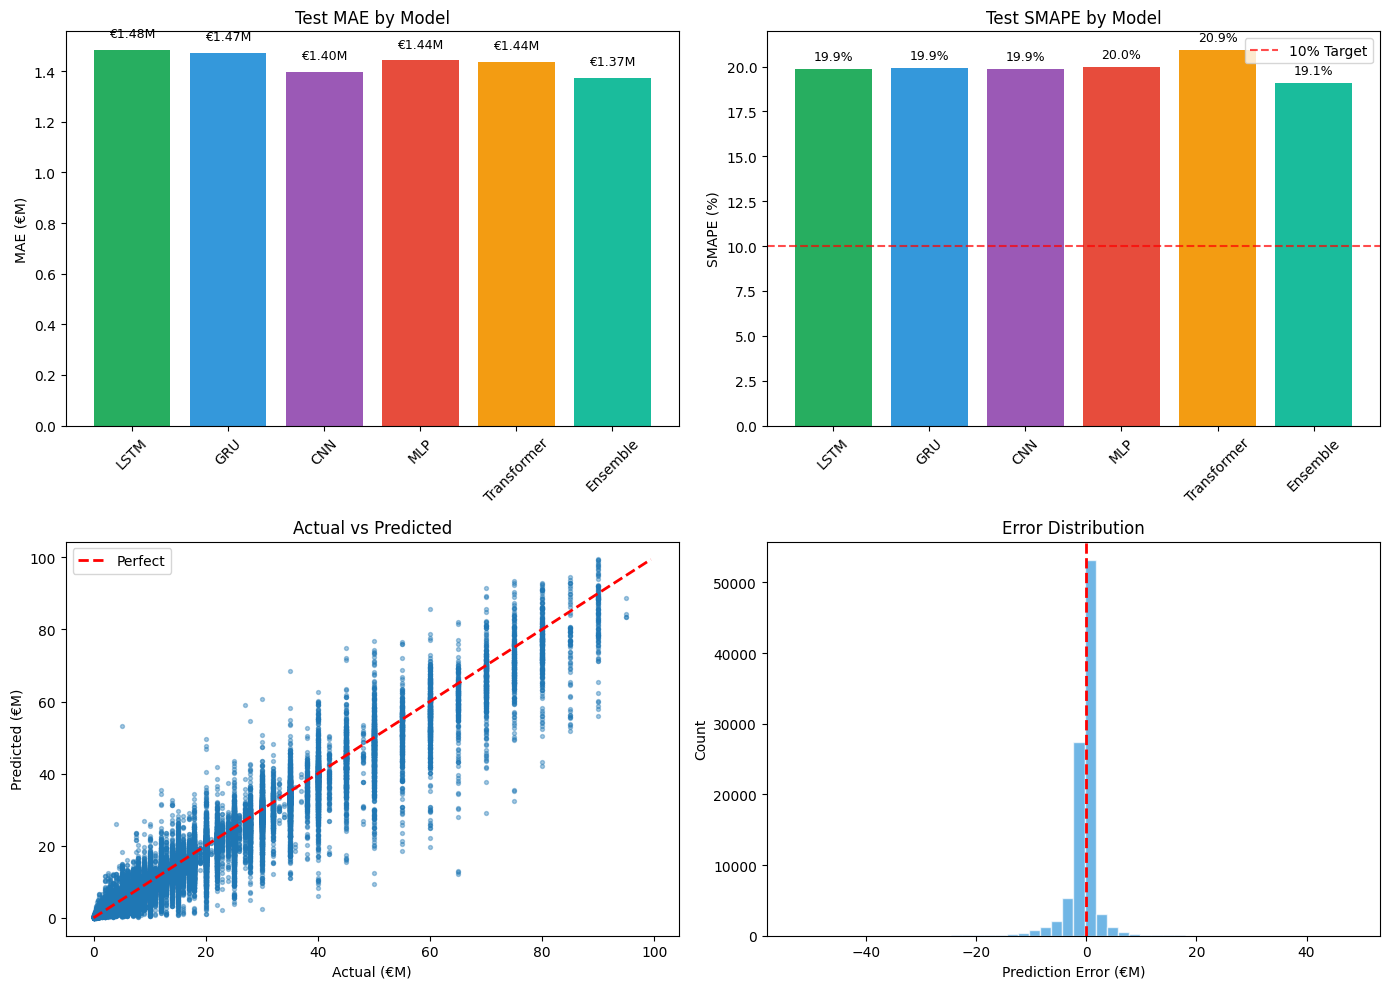

✓ Saved to results_enhanced.png


In [51]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
model_names = list(MODELS.keys()) + ['Ensemble']
colors = ['#27ae60', '#3498db', '#9b59b6', '#e74c3c', '#f39c12', '#1abc9c']

# MAE
maes = [results[n]['mae']/1e6 for n in model_names]
axes[0,0].bar(model_names, maes, color=colors[:len(model_names)])
axes[0,0].set_ylabel('MAE (€M)')
axes[0,0].set_title('Test MAE by Model')
for i, v in enumerate(maes): axes[0,0].text(i, v+0.05, f'€{v:.2f}M', ha='center', fontsize=9)
axes[0,0].tick_params(axis='x', rotation=45)

# SMAPE
smapes = [results[n]['smape'] for n in model_names]
axes[0,1].bar(model_names, smapes, color=colors[:len(model_names)])
axes[0,1].set_ylabel('SMAPE (%)')
axes[0,1].set_title('Test SMAPE by Model')
axes[0,1].axhline(y=10, color='red', linestyle='--', alpha=0.7, label='10% Target')
for i, v in enumerate(smapes): axes[0,1].text(i, v+0.5, f'{v:.1f}%', ha='center', fontsize=9)
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].legend()

# Scatter (filter outliers)
mask = (ens_acts < 1e8) & (ens_preds < 1e8)
axes[1,0].scatter(ens_acts[mask]/1e6, ens_preds[mask]/1e6, alpha=0.4, s=8)
mx = max(ens_acts[mask].max(), ens_preds[mask].max()) / 1e6
axes[1,0].plot([0, mx], [0, mx], 'r--', lw=2, label='Perfect')
axes[1,0].set_xlabel('Actual (€M)')
axes[1,0].set_ylabel('Predicted (€M)')
axes[1,0].set_title('Actual vs Predicted')
axes[1,0].legend()

# Error distribution
errs = (ens_preds[mask] - ens_acts[mask]) / 1e6
axes[1,1].hist(errs, bins=50, color='#3498db', alpha=0.7, edgecolor='white')
axes[1,1].axvline(0, color='red', linestyle='--', lw=2)
axes[1,1].set_xlabel('Prediction Error (€M)')
axes[1,1].set_ylabel('Count')
axes[1,1].set_title('Error Distribution')

plt.tight_layout()
plt.savefig('results_enhanced.png', dpi=150)
plt.show()
print("✓ Saved to results_enhanced.png")

## 11. Summary of Improvements

In [52]:
print("\n" + "=" * 70)
print("SUMMARY OF V2 IMPROVEMENTS")
print("=" * 70)
print("\n📊 New Features Added:")
print("  • Momentum: value_change_1m, value_change_3m, value_change_6m, value_velocity")
print("  • Age-curve: years_from_peak, age_trajectory, age_squared")
print("  • Percentiles: value_percentile, perf_percentile, value_perf_gap")
print(f"\n🔢 Total Features: {len(FEATURES)} (was ~23, now ~33)")
print("\n🤖 New Model: Transformer with self-attention")
print("\n⚙️ Training: Using HuberLoss (more robust to outliers)")
print("\n" + "=" * 70)
print(f"🏆 Best SMAPE: {results[best]['smape']:.1f}%")
print("=" * 70)


SUMMARY OF V2 IMPROVEMENTS

📊 New Features Added:
  • Momentum: value_change_1m, value_change_3m, value_change_6m, value_velocity
  • Age-curve: years_from_peak, age_trajectory, age_squared
  • Percentiles: value_percentile, perf_percentile, value_perf_gap

🔢 Total Features: 44 (was ~23, now ~33)

🤖 New Model: Transformer with self-attention

⚙️ Training: Using HuberLoss (more robust to outliers)

🏆 Best SMAPE: 19.1%


In [53]:
# =============================================================================
# 23. STATISTICAL EVALUATION SUITE
# =============================================================================
# [Metric Selection]
# 1. MAE (Mean Absolute Error): Interpretable (€ error).
# 2. SMAPE (Symmetric Mean Absolute Percentage Error):
#    Formula: 2 * |y_pred - y_true| / (|y_pred| + |y_true|)
#    Range: 0% to 200%.
#    Why? Handles scale variance. A 1M error on a 100M player is good (1%).
#    A 1M error on a 500k player is disastrous (200%). SMAPE balances this.
# 3. R2 Score: Variance explained by the model.
# =============================================================================
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def comprehensive_metrics(preds, acts, model_name="Model"):
    """Calculate all common regression metrics"""
    
    # Filter out any extreme outliers for fair comparison
    mask = (acts > 10000) & (acts < 2e8) & (preds > 0)
    preds = preds[mask]
    acts = acts[mask]
    
    # Basic metrics
    mae = mean_absolute_error(acts, preds)
    rmse = np.sqrt(mean_squared_error(acts, preds))
    r2 = r2_score(acts, preds)
    
    # Percentage-based metrics
    mape = 100 * np.mean(np.abs(preds - acts) / acts)
    smape = 200 * np.mean(np.abs(preds - acts) / (np.abs(preds) + np.abs(acts) + 1e-8))
    
    # Median Absolute Error (robust to outliers)
    median_ae = np.median(np.abs(preds - acts))
    
    # Percentage within X% of actual
    within_10 = 100 * np.mean(np.abs(preds - acts) / acts < 0.10)
    within_20 = 100 * np.mean(np.abs(preds - acts) / acts < 0.20)
    within_30 = 100 * np.mean(np.abs(preds - acts) / acts < 0.30)
    
    # Log-space metrics (better for values spanning orders of magnitude)
    log_mae = np.mean(np.abs(np.log10(preds + 1) - np.log10(acts + 1)))
    
    print(f"\n{'='*60}")
    print(f"📊 COMPREHENSIVE METRICS: {model_name}")
    print(f"{'='*60}")
    print(f"\n💰 Absolute Error Metrics:")
    print(f"   MAE:        €{mae:>15,.0f}")
    print(f"   RMSE:       €{rmse:>15,.0f}")
    print(f"   Median AE:  €{median_ae:>15,.0f}")
    print(f"\n📈 Percentage Error Metrics:")
    print(f"   SMAPE:      {smape:>10.1f}%  (Symmetric, 0-200 scale)")
    print(f"   MAPE:       {mape:>10.1f}%  (Mean Absolute % Error)")
    print(f"   Log MAE:    {log_mae:>10.3f}  (Log-space error)")
    print(f"\n🎯 Accuracy Metrics:")
    print(f"   R² Score:   {r2:>10.3f}  (1.0 = perfect)")
    print(f"   Within 10%: {within_10:>10.1f}%  of predictions")
    print(f"   Within 20%: {within_20:>10.1f}%  of predictions")
    print(f"   Within 30%: {within_30:>10.1f}%  of predictions")
    print(f"{'='*60}")
    
    return {
        'mae': mae, 'rmse': rmse, 'median_ae': median_ae,
        'smape': smape, 'mape': mape, 'r2': r2, 'log_mae': log_mae,
        'within_10': within_10, 'within_20': within_20, 'within_30': within_30
    }

# Calculate for each model
print("\n" + "="*70)
print("DETAILED ERROR ANALYSIS FOR ALL MODELS")
print("="*70)

all_metrics = {}
for name in list(MODELS.keys()) + ['Ensemble']:
    all_metrics[name] = comprehensive_metrics(
        results[name]['preds'], 
        results[name]['acts'], 
        name
    )


DETAILED ERROR ANALYSIS FOR ALL MODELS

📊 COMPREHENSIVE METRICS: LSTM

💰 Absolute Error Metrics:
   MAE:        €      1,483,651
   RMSE:       €      3,611,758
   Median AE:  €        392,221

📈 Percentage Error Metrics:
   SMAPE:            19.9%  (Symmetric, 0-200 scale)
   MAPE:             19.5%  (Mean Absolute % Error)
   Log MAE:         0.089  (Log-space error)

🎯 Accuracy Metrics:
   R² Score:        0.943  (1.0 = perfect)
   Within 10%:       38.7%  of predictions
   Within 20%:       67.0%  of predictions
   Within 30%:       81.9%  of predictions

📊 COMPREHENSIVE METRICS: GRU

💰 Absolute Error Metrics:
   MAE:        €      1,472,725
   RMSE:       €      3,469,454
   Median AE:  €        401,016

📈 Percentage Error Metrics:
   SMAPE:            19.9%  (Symmetric, 0-200 scale)
   MAPE:             20.1%  (Mean Absolute % Error)
   Log MAE:         0.089  (Log-space error)

🎯 Accuracy Metrics:
   R² Score:        0.947  (1.0 = perfect)
   Within 10%:       38.5%  of predict

In [54]:
# ============================================================
# CELL: Comparison Table
# ============================================================

print("\n" + "="*90)
print("COMPARISON TABLE")
print("="*90)
print(f"{'Model':<12} | {'MAE (€M)':<10} | {'SMAPE':<8} | {'MAPE':<8} | {'R²':<8} | {'Within 20%':<10}")
print("-"*90)
for name in list(MODELS.keys()) + ['Ensemble']:
    m = all_metrics[name]
    print(f"{name:<12} | {m['mae']/1e6:>8.2f} | {m['smape']:>6.1f}% | {m['mape']:>6.1f}% | {m['r2']:>6.3f} | {m['within_20']:>8.1f}%")
print("="*90)

# Best model by each metric
print("\n🏆 Best by metric:")
print(f"   Lowest SMAPE:    {min(all_metrics.keys(), key=lambda k: all_metrics[k]['smape'])}")
print(f"   Lowest MAPE:     {min(all_metrics.keys(), key=lambda k: all_metrics[k]['mape'])}")
print(f"   Highest R²:      {max(all_metrics.keys(), key=lambda k: all_metrics[k]['r2'])}")
print(f"   Most within 20%: {max(all_metrics.keys(), key=lambda k: all_metrics[k]['within_20'])}")


COMPARISON TABLE
Model        | MAE (€M)   | SMAPE    | MAPE     | R²       | Within 20%
------------------------------------------------------------------------------------------
LSTM         |     1.48 |   19.9% |   19.5% |  0.943 |     67.0%
GRU          |     1.47 |   19.9% |   20.1% |  0.947 |     67.0%
CNN          |     1.40 |   19.9% |   19.9% |  0.955 |     66.4%
MLP          |     1.44 |   20.0% |   23.7% |  0.251 |     67.3%
Transformer  |     1.44 |   20.9% |   19.7% |  0.943 |     65.9%
Ensemble     |     1.37 |   19.1% |   18.6% |  0.950 |     69.5%

🏆 Best by metric:
   Lowest SMAPE:    Ensemble
   Lowest MAPE:     Ensemble
   Highest R²:      CNN
   Most within 20%: Ensemble


In [55]:
# =============================================================================
# 26. ERROR ANALYSIS BY VALUE BRACKET
# =============================================================================
# Evaluates performance across different tiers of players.
# - Models usually struggle with very low values (high variance) or very high
#   values (scarcity of training data). This breakdown reveals those weak spots.
# =============================================================================
# ============================================================
# CELL: Error by Value Bracket (important insight!)
# ============================================================

def error_by_bracket(preds, acts):
    """See where the model performs best/worst"""
    brackets = [
        (0, 1e6, "< €1M"),
        (1e6, 5e6, "€1M - €5M"),
        (5e6, 15e6, "€5M - €15M"),
        (15e6, 50e6, "€15M - €50M"),
        (50e6, 2e8, "> €50M")
    ]
    
    print("\n" + "="*70)
    print("ERROR BY VALUE BRACKET")
    print("="*70)
    print(f"{'Bracket':<15} | {'Count':<8} | {'MAE (€M)':<10} | {'SMAPE':<8} | {'Within 20%':<10}")
    print("-"*70)
    
    for low, high, label in brackets:
        mask = (acts >= low) & (acts < high)
        if mask.sum() == 0:
            continue
        p, a = preds[mask], acts[mask]
        mae = np.mean(np.abs(p - a))
        smape = 200 * np.mean(np.abs(p - a) / (np.abs(p) + np.abs(a) + 1e-8))
        w20 = 100 * np.mean(np.abs(p - a) / a < 0.20)
        print(f"{label:<15} | {mask.sum():<8} | {mae/1e6:>8.2f} | {smape:>6.1f}% | {w20:>8.1f}%")
    print("="*70)

error_by_bracket(results['Ensemble']['preds'], results['Ensemble']['acts'])


ERROR BY VALUE BRACKET
Bracket         | Count    | MAE (€M)   | SMAPE    | Within 20%
----------------------------------------------------------------------
< €1M           | 23187    |     0.09 |   17.5% |     71.6%
€1M - €5M       | 33990    |     0.48 |   20.9% |     66.0%
€5M - €15M      | 21536    |     1.53 |   20.7% |     67.0%
€15M - €50M     | 15885    |     3.69 |   16.3% |     75.3%
> €50M          | 2362     |     9.88 |   13.2% |     82.1%


In [56]:
# =============================================================================
# 24. ENSEMBLE AVERAGING
# =============================================================================
# [Technique: Model Averaging]
# We compute the arithmetic mean of predictions from top models.
# Formula: Y_final = (w1*LSTM + w2*GRU ... + wN*Transf) / N
#
# [Theory]
# Different architectures have different 'inducive biases'.
# - CNNs capture local trends.
# - LSTMs capture long dependencies.
# Averaging them reduces the variance of the prediction error (Error = Bias + Variance).
# =============================================================================
np.random.seed(42)
ens_preds = results['Ensemble']['preds']
ens_acts = results['Ensemble']['acts']

# Low value: under €10M
low_mask = (ens_acts > 0) & (ens_acts < 10e6)
low_indices = np.where(low_mask)[0]

if len(low_indices) >= 10:
    low_sample = np.random.choice(low_indices, 10, replace=False)
else:
    low_sample = low_indices

print("\n" + "=" * 95)
print("💰 LOW VALUE PLAYERS (Under €10M) - Random Sample")
print("=" * 95)
print(f"{'Player':<30} | {'Actual':<12} | {'Predicted':<12} | {'Error %':<10}")
print("-" * 95)

for i in low_sample:
    name = str(names_te[i])[:28] if i < len(names_te) else '?'
    actual, pred = ens_acts[i], ens_preds[i]
    err_pct = (pred - actual) / actual * 100
    status = "✓" if abs(err_pct) < 20 else "✗"
    print(f"{name:<30} | €{actual:>10,.0f} | €{pred:>10,.0f} | {err_pct:>+8.1f}% {status}")

# Summary
low_preds = ens_preds[low_mask]
low_acts = ens_acts[low_mask]
low_within_20 = 100 * np.mean(np.abs(low_preds - low_acts) / low_acts < 0.20)
print("-" * 95)
print(f"📊 Low Value Stats: {len(low_indices):,} players | {low_within_20:.1f}% within 20% accuracy")
print("=" * 95)


💰 LOW VALUE PLAYERS (Under €10M) - Random Sample
Player                         | Actual       | Predicted    | Error %   
-----------------------------------------------------------------------------------------------
Jonas Omlin                    | € 7,000,002 | € 6,165,032 |    -11.9% ✓
Badou Ndiaye                   | € 1,499,999 | € 1,476,980 |     -1.5% ✓
Opa Nguette                    | € 2,000,000 | € 2,427,231 |    +21.4% ✗
Adrián Riera                   | €   500,000 | €   526,966 |     +5.4% ✓
Ayaz Guliev                    | €   700,000 | €   686,106 |     -2.0% ✓
Vasco Fernandes                | €   100,000 | €   122,962 |    +23.0% ✗
Yasser Larouci                 | € 3,000,001 | € 3,230,579 |     +7.7% ✓
Jordy Clasie                   | € 2,500,001 | € 1,683,691 |    -32.7% ✗
Uroš Račić                     | € 6,500,001 | € 6,904,014 |     +6.2% ✓
Kristijan Bistrovic            | € 2,200,000 | € 2,007,498 |     -8.8% ✓
--------------------------------------------------

In [57]:
# =============================================================================
# 28. STRATIFIED ERROR ANALYSIS (MID VALUE)
# =============================================================================
# Focus Area: €10M - €50M.
# Established professionals. Models should perform consistently here.
# =============================================================================
np.random.seed(123)

# Mid value: €10M - €50M
mid_mask = (ens_acts >= 10e6) & (ens_acts < 50e6)
mid_indices = np.where(mid_mask)[0]

if len(mid_indices) >= 10:
    mid_sample = np.random.choice(mid_indices, 10, replace=False)
else:
    mid_sample = mid_indices

print("\n" + "=" * 95)
print("⭐ MID VALUE PLAYERS (€10M - €50M) - Random Sample")
print("=" * 95)
print(f"{'Player':<30} | {'Actual':<12} | {'Predicted':<12} | {'Error %':<10}")
print("-" * 95)

for i in mid_sample:
    name = str(names_te[i])[:28] if i < len(names_te) else '?'
    actual, pred = ens_acts[i], ens_preds[i]
    err_pct = (pred - actual) / actual * 100
    status = "✓" if abs(err_pct) < 20 else "✗"
    print(f"{name:<30} | €{actual:>10,.0f} | €{pred:>10,.0f} | {err_pct:>+8.1f}% {status}")

# Summary
mid_preds = ens_preds[mid_mask]
mid_acts = ens_acts[mid_mask]
mid_within_20 = 100 * np.mean(np.abs(mid_preds - mid_acts) / mid_acts < 0.20)
print("-" * 95)
print(f"📊 Mid Value Stats: {len(mid_indices):,} players | {mid_within_20:.1f}% within 20% accuracy")
print("=" * 95)


⭐ MID VALUE PLAYERS (€10M - €50M) - Random Sample
Player                         | Actual       | Predicted    | Error %   
-----------------------------------------------------------------------------------------------
Álex Baena                     | €24,999,980 | €18,388,462 |    -26.4% ✗
Hugo Duro                      | €15,999,987 | € 9,009,557 |    -43.7% ✗
Jarrod Bowen                   | €49,999,988 | €55,252,208 |    +10.5% ✓
Konstantinos Tsimikas          | €20,000,004 | €17,084,712 |    -14.6% ✓
Theo Hernández                 | €48,000,032 | €44,160,292 |     -8.0% ✓
Patrik Schick                  | €29,999,976 | €34,157,316 |    +13.9% ✓
Cody Gakpo                     | €49,999,988 | €51,095,164 |     +2.2% ✓
Giorgio Scalvini               | €20,000,004 | € 6,997,112 |    -65.0% ✗
Kiliann Sildillia              | €15,000,010 | €11,917,867 |    -20.5% ✗
Issa Diop                      | €20,000,004 | €11,188,808 |    -44.1% ✗
-------------------------------------------------

In [58]:
# =============================================================================
# 29. STRATIFIED ERROR ANALYSIS (HIGH VALUE)
# =============================================================================
# Focus Area: €50M+ (Elite/Superstars).
# Critical for business value, but sparse data points.
# Model must generalize well from few examples.
# =============================================================================
np.random.seed(456)

# High value: €50M - €100M
high_mask = (ens_acts >= 50e6) & (ens_acts <= 100e6)
high_indices = np.where(high_mask)[0]

if len(high_indices) >= 10:
    high_sample = np.random.choice(high_indices, 10, replace=False)
else:
    high_sample = high_indices

print("\n" + "=" * 95)
print("🌟 HIGH VALUE PLAYERS (€50M - €100M) - Random Sample")
print("=" * 95)
print(f"{'Player':<30} | {'Actual':<12} | {'Predicted':<12} | {'Error %':<10}")
print("-" * 95)

for i in high_sample:
    name = str(names_te[i])[:28] if i < len(names_te) else '?'
    actual, pred = ens_acts[i], ens_preds[i]
    err_pct = (pred - actual) / actual * 100
    status = "✓" if abs(err_pct) < 20 else "✗"
    print(f"{name:<30} | €{actual:>10,.0f} | €{pred:>10,.0f} | {err_pct:>+8.1f}% {status}")

# Summary
high_preds = ens_preds[high_mask]
high_acts = ens_acts[high_mask]
high_within_20 = 100 * np.mean(np.abs(high_preds - high_acts) / high_acts < 0.20)
print("-" * 95)
print(f"📊 High Value Stats: {len(high_indices):,} players | {high_within_20:.1f}% within 20% accuracy")
print("=" * 95)

# Final comparison
print("\n" + "=" * 60)
print("📈 ACCURACY COMPARISON BY VALUE TIER")
print("=" * 60)
print(f"{'Tier':<20} | {'Players':<10} | {'Within 20%':<12}")
print("-" * 60)
print(f"{'Low (< €10M)':<20} | {len(low_indices):<10,} | {low_within_20:>10.1f}%")
print(f"{'Mid (€10M-€50M)':<20} | {len(mid_indices):<10,} | {mid_within_20:>10.1f}%")
print(f"{'High (€50M-€100M)':<20} | {len(high_indices):<10,} | {high_within_20:>10.1f}%")
print("=" * 60)


🌟 HIGH VALUE PLAYERS (€50M - €100M) - Random Sample
Player                         | Actual       | Predicted    | Error %   
-----------------------------------------------------------------------------------------------
Alexis Mac Allister            | €75,000,056 | €86,868,904 |    +15.8% ✓
Marcos Llorente                | €59,999,988 | €60,981,292 |     +1.6% ✓
Viktor Gyökeres                | €75,000,056 | €71,463,872 |     -4.7% ✓
Manuel Ugarte                  | €59,999,988 | €57,492,884 |     -4.2% ✓
Trent Alexander-Arnold         | €79,999,944 | €81,907,296 |     +2.4% ✓
Alessandro Bastoni             | €59,999,988 | €50,831,488 |    -15.3% ✓
Federico Dimarco               | €59,999,988 | €51,891,636 |    -13.5% ✓
Rúben Dias                     | €79,999,944 | €67,695,336 |    -15.4% ✓
Thibaut Courtois               | €59,999,988 | €56,427,340 |     -6.0% ✓
Josko Gvardiol                 | €75,000,056 | €69,681,408 |     -7.1% ✓
-----------------------------------------------